# Cricket Pose-Based Biomechanics Analysis

This notebook demonstrates a pose-based movement analysis pipeline for a cricket player
using a side-view phone-recorded video.

**Goals:**
- Extract human pose keypoints from video
- Analyze movement using interpretable biomechanics metrics
- Evaluate pose stability and limitations

Focus is on *clarity of thinking*, not perfect accuracy.

---


## Pipeline Overview

This notebook implements a sports analytics pipeline for cricket using computer vision.
The pipeline consists of:

1. Pose estimation using YOLOv8 Pose
2. Extraction of 2D joint keypoints per frame
3. Joint angle computation (knee and elbow)
4. Derivation of biomechanical performance metrics
5. Visualization of joint dynamics over time
-----

## Movement Metrics Rationale

The selected metrics capture both lower-body and upper-body biomechanics:

- Knee Range of Motion reflects lower-body engagement and flexibility.
- Knee Stability Variance indicates balance and control during motion.
- Elbow Range of Motion measures arm extension, relevant to batting and bowling mechanics.

Together, these metrics provide a concise yet meaningful assessment of cricket movement quality.


---



**Installs all required dependencies for**

* Pose estimation (YOLOv8 Pose)

* Video processing

* Numerical computation

* Metric visualization

In [1]:
!pip install ultralytics opencv-python numpy pandas matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.3 MB/s eta 0:00:00


**Import Libraries**

*Sets up tools for*:

* Reading and writing videos

* Running pose estimation

* Computing joint angles

* Storing and plotting results

In [26]:
import cv2
from ultralytics import YOLO
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import acos, degrees


**Define Input & Output Paths + Load Model**

* Defines clear separation between input video and outputs

* Loads a pretrained YOLOv8 Pose model

*Why YOLOv8 Pose?*

* Stable in notebook environments

* Provides reliable keypoints

* No fine-tuning required (as per PDF)



In [27]:
input_video_path = "/content/SampleSideonSideBatting.mov"
output_video_path = "/content/output.mp4"
keypoints_csv_path = "/content/keypoints.csv"
metrics_csv_pth = "/content/metrics.csv"

model = YOLO("yolov8n-pose.pt")


**Open Video & Initialize Video Writer**

* Reads the cricket video frame-by-frame

* Prepares an output file for skeleton overlay video

In [28]:
cap = cv2.VideoCapture(input_video_path)

vd_fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_video_path, fourcc, vd_fps, (w, h))


**Define Skeleton Connections (COCO Format)**

* Defines how keypoints are connected to form a human skeleton

* Uses standard COCO pose indexing

In [29]:
SKELETON = [
    (5,7), (7,9),        # left arm
    (6,8), (8,10),       # right arm
    (11,13), (13,15),    # left leg
    (12,14), (14,16),    # right leg
    (5,6), (11,12),      # shoulders
    (5,11), (6,12)
]


**Core Pose Estimation Pipeline**

*For each frame:*

* YOLOv8 detects the human pose

* Extracts 17 body keypoints

* Saves frame-wise (x, y) coordinates

* Draws skeleton overlay

* Writes annotated frame to output video

In [30]:
keypoints_data = []
frame_id = 0
detected_frames = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame, verbose=False)

    if results and results[0].keypoints is not None:
        kp = results[0].keypoints.xy

        if len(kp) > 0:  # at least one person
            person = kp[0].cpu().numpy()
            detected_frames += 1

            row = {"frame": frame_id}
            for i, (x, y) in enumerate(person):
                row[f"x_{i}"] = x
                row[f"y_{i}"] = y

            keypoints_data.append(row)

    frame_id += 1

cap.release()

print("Total frames:", frame_id)
print("Frames with pose detected:", detected_frames)


Total frames: 187
Frames with pose detected: 187


**Save Frame-Wise Keypoints**

* Converts extracted keypoints into a structured CSV

* Enables quantitative movement analysis

In [31]:
df = pd.DataFrame(keypoints_data)
df.to_csv(keypoints_csv_path, index=False)
df.head()


,frame,x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3,x_4,...,x_12,y_12,x_13,y_13,x_14,y_14,x_15,y_15,x_16,y_16
0,0,909.228516,227.830490,919.592896,214.493408,894.573730,213.002380,921.413269,222.590973,854.811584,...,807.470215,519.111389,928.217285,694.895569,764.053711,695.090454,951.057495,863.101379,736.228699,862.586243
1,1,906.820679,225.204437,916.131592,212.072845,892.685730,210.844299,915.982727,222.007416,853.890198,...,811.979980,517.706177,928.136536,690.171936,766.398376,691.923584,950.394897,860.783264,736.888428,861.278748
2,2,910.032227,225.230164,918.418823,212.116791,896.207764,211.278076,916.436462,221.918839,857.503845,...,813.599365,517.902954,927.646912,688.947510,767.549133,692.429871,950.547424,857.632324,736.036194,860.157532
3,3,908.721741,225.854965,917.321411,212.036362,893.901489,212.103424,916.790833,220.829956,854.761414,...,812.061401,517.125061,926.812683,686.777649,769.574585,691.386169,952.358643,855.497925,740.028931,858.188660
4,4,904.736450,238.241547,913.309631,225.070312,892.276794,224.328964,914.701233,230.186920,856.962769,...,813.733154,515.610168,925.406433,680.280884,778.461182,683.675720,947.715515,851.606873,753.658142,851.309937


**Joint Angle Helper Function**
* Computes the angle at joint b using three keypoints

* Core mathematical function for biomechanics metrics

In [32]:
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    cos_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    return degrees(acos(np.clip(cos_angle, -1.0, 1.0)))


**Elbow Joint Angle Computation**

This code computes the elbow joint angle for each video frame, which serves as the 3rd movement metric required by the assignment.

----


**These indices correspond to YOLOv8 pose keypoints:**

(SHOULDER, ELBOW, WRIST = 6, 8, 10)

* Shoulder

* Elbow

* Wrist
---

**For each frame**

* Uses shoulder, elbow, and wrist coordinates

* Calculates the elbow angle at the elbow joint

* Stores the value (in degrees) in df["elbow_angle"]

**Why this metric matters**

*Elbow extension is crucial for:*

* Bowling legality

* Batting power

* Injury prevention

In [33]:
SHOULDER, ELBOW, WRIST = 6, 8, 10

df["elbow_angle"] = df.apply(
    lambda r: calculate_angle(
        (r[f"x_{SHOULDER}"], r[f"y_{SHOULDER}"]),
        (r[f"x_{ELBOW}"], r[f"y_{ELBOW}"]),
        (r[f"x_{WRIST}"], r[f"y_{WRIST}"])
    ),
    axis=1
)


**Knee Joint Angle Computation**

This cell calculates the knee joint angle for every frame, forming the basis for multiple lower-body metrics.

---
**These indices represent:**


(HIP, KNEE, ANKLE = 11, 13, 15)

* Hip

* Knee

* Ankle
----
**For Each Frame**

* Computes the angle at the knee joint for each frame

* Stores the result in df["knee_angle"]

**Why this metric matters**

*Knee mechanics are critical for:*

* Balance

* Power transfer

* Injury risk assessment

This is a core biomechanics metric in sports analytics.

In [34]:
HIP, KNEE, ANKLE = 11, 13, 15

df["knee_angle"] = df.apply(
    lambda r: calculate_angle(
        (r[f"x_{HIP}"], r[f"y_{HIP}"]),
        (r[f"x_{KNEE}"], r[f"y_{KNEE}"]),
        (r[f"x_{ANKLE}"], r[f"y_{ANKLE}"])
    ),
    axis=1
)


**Metric Aggregation (Scalar Metrics)**

Convert raw joint-angle time series into interpretable scalar performance metrics.

---
**Metrics Computed**


*Knee Range of Motion (ROM)*

* Measures total angular movement of the knee

* Indicates flexibility and lower-body engagement

*Knee Stability Variance*


* Measures variability of knee angle over time

* Higher variance may indicate rapid movement or instability

*Elbow Range of Motion*

* Measures arm extension and flexion

* Relevant for bowling and batting mechanics



In [ ]:
elbow_rom = df["elbow_angle"].max() - df["elbow_angle"].min()

rom = df["knee_angle"].max() - df["knee_angle"].min()
stability = df["knee_angle"].var()

**Metrics Table Creation**

Organize computed metrics into a structured, readable format.

---



In [35]:

metrics_df = pd.DataFrame({
    "Metric": [
        "Knee Range of Motion",
        "Knee Stability Variance",
        "Elbow Range of Motion"
    ],
    "Value": [
        rom,
        stability,
        elbow_rom
    ]
})

metrics_df



,Metric,Value
0,Knee Range of Motion,67.856748
1,Knee Stability Variance,357.906095
2,Elbow Range of Motion,89.889226


In [ ]:
metrics_df.to_csv("movement_metrics.csv", index=False)


**Visualization – Knee Angle Over Time**

Visualize knee joint dynamics across the full motion sequence.

---
**What this shows**

* Temporal evolution of knee angle

*Identifies:*

- Flexion/extension phases

- Sudden spikes or instability

- Motion consistency

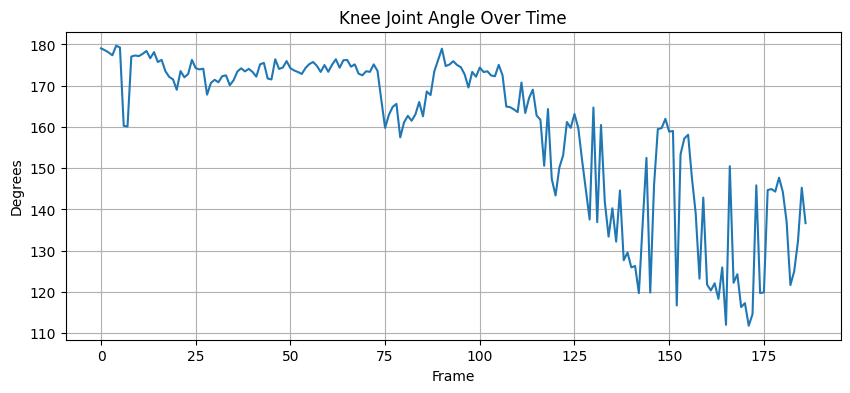

In [36]:
plt.figure(figsize=(10,4))
plt.plot(df["knee_angle"])
plt.title("Knee Joint Angle Over Time")
plt.xlabel("Frame")
plt.ylabel("Degrees")
plt.grid()
plt.show()



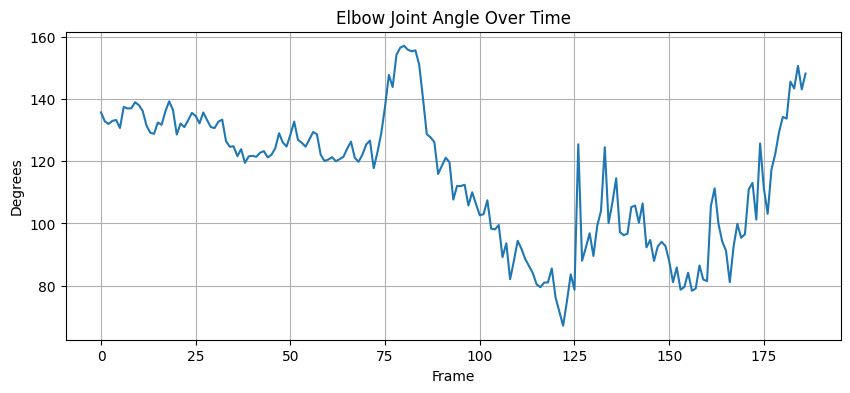

In [37]:
plt.figure(figsize=(10,4))
plt.plot(df["elbow_angle"])
plt.title("Elbow Joint Angle Over Time")
plt.xlabel("Frame")
plt.ylabel("Degrees")
plt.grid()
plt.show()


## Results Interpretation

The knee joint exhibited a range of motion of approximately 68°, indicating effective
lower-body engagement during the movement. The relatively high knee stability variance
suggests either rapid dynamic motion or pose estimation noise, which is expected in
single-view 2D analysis.

The elbow range of motion (~90°) indicates significant arm extension, aligning with
typical cricket batting or bowling mechanics.

---




## Limitations and Future Improvements

- The analysis relies on 2D pose estimation, which lacks depth information.
- Occlusions and fast motion may introduce noise in keypoint detection.
- Future work could include temporal smoothing, multi-view capture, or 3D pose estimation.


## Conclusion

This project demonstrates how pose estimation and simple biomechanical metrics can be
used to analyze cricket movement patterns using only video input.
